In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from datetime import datetime, time

# Data source: Protezione civile, official Italian goverment press release

### http://www.protezionecivile.gov.it/web/guest/media-comunicazione/comunicati-stampa

### CSV File available on GitHub
https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.

### Infographics from Italian Government
http://opendatadpc.maps.arcgis.com/apps/opsdashboard/index.html#/b0c68bce2cce478eaac82fe38d4138b1


In [72]:
#Italian population. We need it for later
#N_ita = 60.48*np.power(10,6)
#covid19_daily = pd.read_csv('./Coronavirus_Data_Italia.csv',parse_dates=['Data'])
#covid19_daily.index = pd.to_datetime(covid19_daily.Data, dayfirst=True)
#covid19_daily.dtypes

#Italian population. We need it for later
N_ita = 60.48*np.power(10,6)
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
covid19_daily = pd.read_csv(url)
covid19_daily.shape
#covid19_daily.index = pd.to_datetime(covid19_daily.data, format="%Y-%m-%d %H:%M:%S")
covid19_daily['data']=pd.to_datetime(covid19_daily['data'],format="%Y-%m-%d %H:%M:%S")
#covid19_daily.head(3)

### Translate header in english

In [73]:
covid19_daily.columns = ['date', 'country', 'checked_in','intensive_care','total_admitted','home_isolation','currently_positive','new_cases','recovered','deceased','total_cases','swabs']
covid19_daily

,date,country,checked_in,intensive_care,total_admitted,home_isolation,currently_positive,new_cases,recovered,deceased,total_cases,swabs
0,2020-02-24 18:00:00,ITA,101,26,127,94,221,221,1,7,229,4324
1,2020-02-25 18:00:00,ITA,114,35,150,162,311,90,1,10,322,8623
2,2020-02-26 18:00:00,ITA,128,36,164,221,385,74,3,12,400,9587
3,2020-02-27 18:00:00,ITA,248,56,304,284,588,203,45,17,650,12014
4,2020-02-28 18:00:00,ITA,345,64,409,412,821,233,46,21,888,15695
5,2020-02-29 18:00:00,ITA,401,105,506,543,1049,228,50,29,1128,18661
6,2020-03-01 18:00:00,ITA,639,140,779,798,1577,528,83,34,1694,21127
7,2020-03-02 18:00:00,ITA,742,166,908,927,1835,258,149,52,2036,23345
8,2020-03-03 18:00:00,ITA,1034,229,1263,1000,2263,428,160,79,2502,25856
9,2020-03-04 18:00:00,ITA,1346,295,1641,1065,2706,443,276,107,3089,29837


In [74]:
#Function which computes the time passed between two dates. The outputs is in seconds
def date_diff_in_Seconds(dt2, dt1):
  timedelta = dt2 - dt1
  return timedelta.days * 24 * 3600 + timedelta.seconds

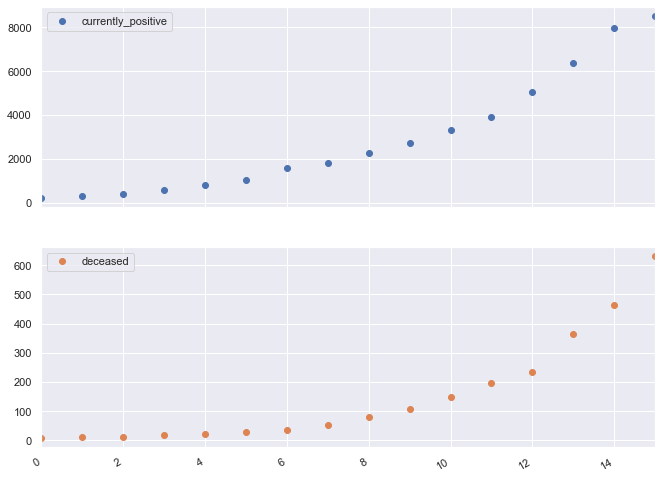

In [75]:
#Seaborn setup for plots
sns.set(rc={'figure.figsize':(11, 7)})
cols_plot = ['currently_positive', 'deceased']
axes = covid19_daily[cols_plot].plot(marker='o', linestyle='None', figsize=(11, 9), subplots=True)

# Concepts: SIR Model, SIS Model and Verhulst growth

It has been hundreds of years since we started using math to try and predict the diffusion of diseases. The first one to attempt a proper statistical analysis was the physician, physicist and mathematician Daniel Bernoulli who, with some rudimental techniques, argued for the benefits of inoculations (today we call them vaccinations) against smallpox. In 1766 he analyzed morbidity and mortality data to demonstrate the efficacy of vaccination$^1$

[1] https://web.archive.org/web/20070927032605/http://www.semel.ucla.edu/biomedicalmodeling/pdf/Bernoulli%26Blower.pdf

Here is an overview of the various ways we use to model the dynamics of Infectious disease, taken from
*Mathematical modeling of infectious disease dynamics*
Constantinos I. Siettos, Lucia Russo, Virulence. 2013 May 15; 4(4): 295–306.
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3710332/

![title](./Overview.png)

The core set of ideas I used was developed in 1927 by Kermack and McKendrick in *A Contribution to the Mathematical Theory of Epidemics*, which can be found in Proceedings of the Royal Society A. 115 (772): 700–721 at doi:10.1098/rspa.1927.0118 and it goes under the name of **Compartmental Modeling**. In its most basic form it divides a certain population, with $N$ individuals, into three basics compartments:
- **Susceptibles** = People who still don't have the disease and might catch it
- **Infected** = People with the disease
- **Removed** = People that can not have the disease as they are immune or dead
Calling $S(t)$, $I(t)$ and $R(t)$ respectively the susceptibles, infected and removed, we have the constraint
\begin{align}
S(t) + I(t) + R(t) = N
\end{align}

Each individual within each compartment is assumed to behave the same way, so we are simply interested in the total number of people belonging to a compartment. This is called the SIR Model without vital dynamics as the natural birth/death dynamics of the population is not taken into account. This is usually a decent approximation as the natural dynamics of an epidemic is quite faster with respect to the natural dynamics of the population. However, this is not always so. In 2018 we had 439.747 new babies over the whole year but 633.133 people died. This gives an average daily variation of the population of circa +530 people. Given that we have about 60 million people, we conclude that we can safely neglect the vital dynamics and consider the population $N$ as a fixed number as the annual variation rate is circa 0.3%.

The basic idea behind the SIR model is that a typical individual will go through the following stages. For a full review you can check SIAM Review 42, No. 4, pp. 599-653 *The Mathematics of Infectious Diseases* http://leonidzhukov.net/hse/2014/socialnetworks/papers/2000SiamRev.pdf

![title](./SIR_Graphic.png)

The main assumptions of the SIR model are in the transition rates. The transition between susceptibles and Infectious is simply proportional to the number of infectious and susceptibles, the transition rate being called β, where β is considered as the average number of contacts times the probability of disease transmission in a contact between a susceptible and an infectious.

Between Infectious and Removed the transition rate is called γ and it is simply the rate of recovery and/or death. Usually γ is interpreted as γ = 1/T, with T being the mean infective period. With these assumptions we obtain a set of differential equations can that be used to study the dynamics of diseases spreading:

### SIR Model differential equations

\begin{align}
& \frac{dS}{dt} = - \beta \frac{IS}{N} &&  \frac{dI}{dt} = \beta \frac{IS}{N} - \gamma I &&& \frac{dR}{dt} = \gamma I
\end{align}

### SIS Model: No immunity

If we are dealing with a disease that does not provide immunity, as the common cold or the influenza. This means that there are no removed and therefore we only have two compartments: Susceptible and Infectious:
\begin{align}
& \frac{dS}{dt} = - \beta \frac{IS}{N} + \gamma I &&I(t) = N -S(t)
\end{align}
Extracting the differential equation for $I(t)$ we obtain the logistic equation, which in the context of population dynamics goes under the name of Verhulst growth model.

### Verhulst growth model

\begin{equation}
\frac{dI}{dt} = (\beta N - \gamma) I - \beta I^2 = r I\left(1 - \frac{I}{K}\right) \quad \mathrm{with} \quad r = \beta N - \gamma \qquad \mathrm{and} \qquad K = \frac{\beta N - \gamma}{\beta} \qquad \qquad N_{italy} = 60.48 \times 10^{6}
\end{equation}

The equation can be solved analytically, leading to:

\begin{equation}
I(t) = \frac{K}{1+\left( \frac{K - I_0}{I_0}\right)e^{-r(t-t_0)}} \qquad \qquad I_0 = I(t_0)
\end{equation}

The two parameters $r$ and $K$ that parametrize the evolution are, respectively, the **growth rate** and the **Carrying Capacity**. The first one parametrizes the exponential growth that characterizes the beginning of the growth. Thus, we will start noticing an exponential increase on a time-scale of the order $\tau \sim 1/r $. However, after a few $\tau$s the growth will "feel the finiteness of resources", thus modifying its exponential behaviour into a linear one and then saturating on a value that is exactly $K$.  

In terms of population dynamics, the carrying capacity is the number of individuals an environment can support without changing the organism, or the conditions around it. Below $K$ a populations will typically grow, while above it will typically decrease. The carrying capacity of a biological species, in a fixed environment, is the maximum population size that an environment with fixed resources can sustain. In this case we are modeling the spread of COVID-19, which can be thought of as the growth of an *infected compartment*, whose resources are simply the number of people that do not carry the virus, the number of susceptibles.

At the beginning the growth is exponential as the first term $rI$ is the dominant one for the derivative. However later the second term $\frac{rI^2}{K}$ starts to become relevant as, using the population dynamics interpretation, different individuals start to compete for the same resources. This occurs when different instances of the disease start to interfere with each other and compete for the same resources. For example this can happen because, as more  people get sick and we do more tests, we start implementing appropriate measures as quarantine for the infected. If that is not enough, as it is happening in Italy, forced isolation seem to be the best way to go. 


To understand that we need to exploit the twofold nature of the model we are analyzing: as Verhuslt growth model and as SIS model for infectious disease. We start asking ourselves, what is the major resource of the disease, for which the various instances of the disease are competing? It is the number of susceptibles $S(t) = N - I(t)$. In this phase, this can be still approximated with $N$ itself as it is way larger than the total number of infected people, and we would like to keep it that way. 

Hence, we consider $N$ as the main resource. 

The best way to go forward is to *suffocate* the disease by **taking away its resources**. Isolation is the way to go as, what it truly does, is to **drastically lower the effective value of N** by taking away large chunks of the population which will not come into contact with the infected. It is quite easy to prove that, even if we maintain the rates $\left( \beta, \gamma\right)$ a lower value $N_{\mathrm{eff}}<N$ turns into a effectively lower values of the growth rate **and** of the carrying capacity. The rest will be taken care of by the natural anatagonistic effect that is built into the logistic growth:

\begin{equation}
N_{\mathrm{eff}} < N \qquad \Longrightarrow \qquad \left\{ \begin{array}{l}
 K_{\mathrm{eff}} < K \\
 r_{\mathrm{eff}} < r 
  \end{array} \right.
\end{equation}

This can be easily seen by looking at the equation that define $(r,K)$ as functions of $\beta,\gamma$ and $N$:

\begin{equation}
\left\{ \begin{array}{l}
\beta = \frac{r}{K} = \frac{r_{\mathrm{eff}}}{K_{\mathrm{eff}}} \\
\\
\frac{\gamma}{\beta} = N-K = N_{\mathrm{eff}} - K_{\mathrm{eff}}
  \end{array} \right. \qquad \mathrm{hence} \qquad N_{\mathrm{eff}} < N \quad \Longrightarrow \quad \left\{ \begin{array}{l}
K_{\mathrm{eff}} < K\\
\\
r_{\mathrm{eff}} < r
  \end{array} \right.
\end{equation}

Thus lowering the actual resources of the disease will bring two beneficial aspects. On the one side, it will slow down its natural exponential increase by changing growth rate. On the other side, it will lower the carrying capacity, which is total number of people that will have the disease in the long run, which is exactly what we need to avoid the saturation of the healthcare system.

# Analysis on the number of positive cases

In [76]:
#Turn the pandas dataframe into numpy arrays to run curve_fit on them
length = covid19_daily.shape[0]
tdata = np.zeros(length) 
ydata = np.zeros(length)
for k in range(length):
    tdata[k] = date_diff_in_Seconds(covid19_daily['date'][k],covid19_daily['date'][0])/3600 #This way the time 
    #scale is in hours
    ydata[k] = covid19_daily['currently_positive'][k]  

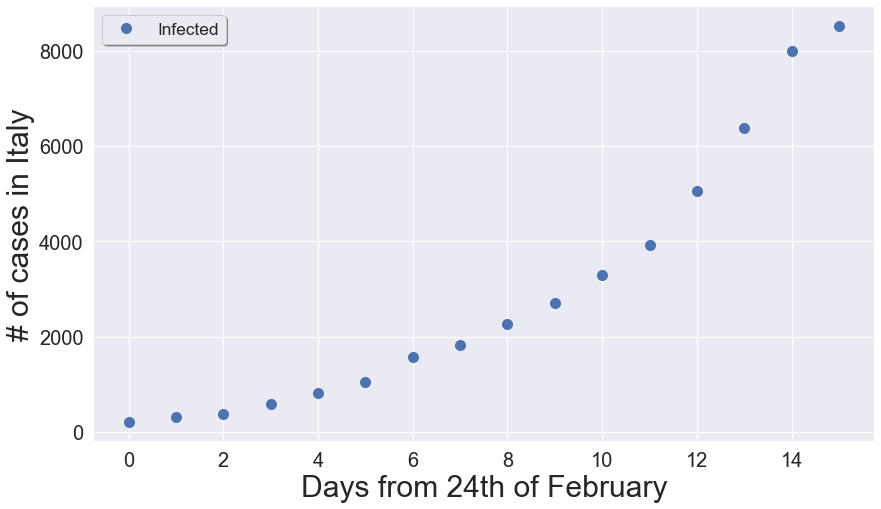

In [77]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(tdata/24, ydata, 'o', label='Infected',markersize=10)
ax.tick_params(labelsize=20)
plt.xlabel('Days from 24th of February',fontsize=30)
plt.ylabel('# of cases in Italy',fontsize=30)
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.savefig('./Plots/COVID-19_Cases_Italy_JustData.png')
plt.show()

In [78]:
#Define the function to use for curve_fit. Here we are useing the Verhulst model, which is a logistic (sigmoid) function with 3 parameters
def Verhulst(t, K, I0, r):
    return (K*I0*np.exp(r*t))/(K+I0*(np.exp(r*t)-1))

def Exponential(t, tau, a):
    return a*np.exp(t/tau)

In [79]:
#Fit the data on the number of cases with an exponential curve and a Verhulst model
popt_exp, pcov_exp = curve_fit(Exponential, tdata[0:7], ydata[0:7],bounds=([0,0],[1000,1000]))
popt, pcov = curve_fit(Verhulst, tdata, ydata, bounds=([0,0,0],[60000000,1000,1]))

In [80]:
#Define an array of "Future data" to continue the plot and extract a prediction
future_tdata = np.linspace(tdata[-1],tdata[-1]+200,num=100)
new_tdata = np.append(tdata,future_tdata)

### Plot of the exponential and Verhulst fit, with data on the number of infected cases

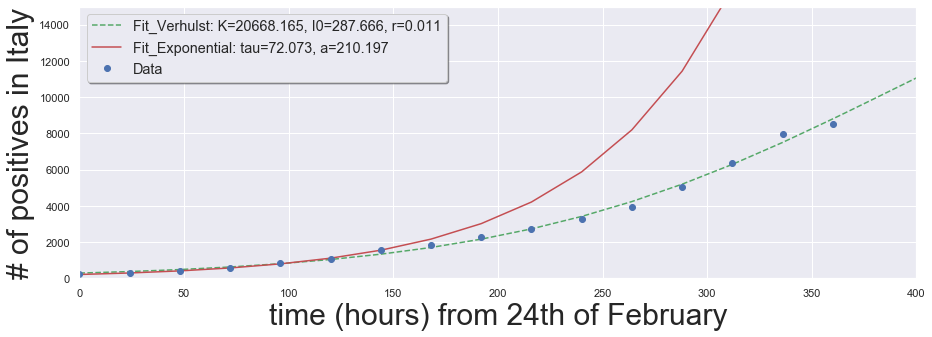

In [92]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(new_tdata, Verhulst(new_tdata, *popt), 'g--', label='Fit_Verhulst: K=%5.3f, I0=%5.3f, r=%5.3f' % tuple(popt))
ax.plot(new_tdata,Exponential(new_tdata,*popt_exp),'r',label='Fit_Exponential: tau=%5.3f, a=%5.3f' % tuple(popt_exp))
ax.plot(tdata, ydata, 'o', label='Data')
plt.xlabel('time (hours) from 24th of February',fontsize=30)
plt.ylabel('# of positives in Italy',fontsize=30)
ax.set_ylim([0,15000])
ax.set_xlim([0,400])
legend = ax.legend(loc='upper left', shadow=True, fontsize='large')

plt.savefig('./Plots/COVID-19_Cases_Italy_Params.png')
plt.show()

### Better plot on the number of cases

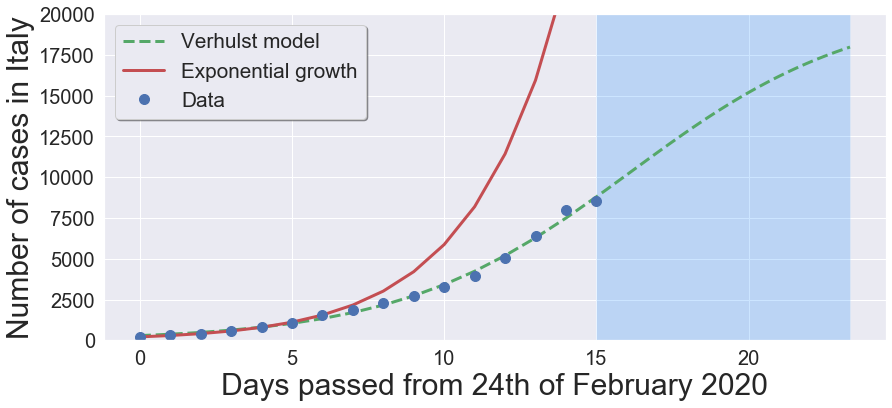

In [93]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(new_tdata/24, Verhulst(new_tdata, *popt), 'g--', label='Verhulst model',linewidth=3)
ax.plot(new_tdata/24,Exponential(new_tdata,*popt_exp),'r',label='Exponential growth',linewidth=3)
ax.plot(tdata/24, ydata, 'o', label='Data',markersize=10)
ax.tick_params(labelsize=20)
plt.ylabel('Number of cases in Italy',fontsize=30)
plt.xlabel('Days passed from 24th of February 2020',fontsize=30)
ax.set_ylim([0,20000])
legend = ax.legend(loc='upper left', shadow=True, fontsize='xx-large')
plt.axvspan(tdata[-1]/24,new_tdata[-1]/24, facecolor='#0080FF', alpha=0.2)
#plt.xticks(tdata,covid19_daily['Data'],rotation=50)
plt.savefig('./Plots/COVID-19_Cases_Italy.png')
plt.show()


### Parameters of the fit, with their error - Verhulst Model

In [94]:
#K = popt[0], P0 = popt[1], r = popt[2]
delta_r = np.sqrt(pcov[2,2])
delta_K = np.sqrt(pcov[0,0])
from prettytable import PrettyTable
t = PrettyTable(['Verhulst Parameters', 'Value','Error'])
t.add_row(['r', popt[2], delta_r])
t.add_row(['K', popt[0], delta_K])
print(t)

+---------------------+---------------------+-----------------------+
| Verhulst Parameters |        Value        |         Error         |
+---------------------+---------------------+-----------------------+
|          r          | 0.01100246358476564 | 0.0008830556138927052 |
|          K          |  20668.165467717776 |   5176.588272430213   |
+---------------------+---------------------+-----------------------+


### 1-Sigma confidence intervals for the Verhulst parameters

\begin{align}
& r = \left( 11 \pm 0.9\right) \times 10^{-3} \sim \left[ \, 10.1 \,,\, 11.9\,\right]  \times 10^{-3} && &&& K = \left(20.7 \pm 5.2 \pm \right) \times 10^{3} \sim \left[\, 15.5 \, , \, 25.9 \, \right] \times 10^{3}
\end{align}

### Convert the Verhulst parameters (r,K) into the SIS Model parameters ($\beta$, $\gamma$) and compute the errors

In [95]:
beta = popt[2]/popt[0]
gamma = beta*N_ita-popt[2]
R0 = N_ita/(N_ita-popt[2])
delta_beta = np.sqrt(np.power(delta_r/popt[0],2)+np.power(popt[2]/(np.power(popt[0],2)),2))
delta_gamma = np.sqrt(np.power((N_ita/popt[0]-1)*delta_r,2)+np.power((popt[2]*N_ita/(np.power(popt[0],2)))*delta_K,2))

In [96]:
from prettytable import PrettyTable
t = PrettyTable(['SIS Model Parameters', 'Value','Error'])
t.add_row(['beta', beta, delta_beta])
t.add_row(['gamma', gamma, delta_gamma])
print(t)

+----------------------+----------------------+-----------------------+
| SIS Model Parameters |        Value         |         Error         |
+----------------------+----------------------+-----------------------+
|         beta         | 5.32338663629857e-07 | 4.272540665153389e-08 |
|        gamma         |  32.184839912748984  |   8.467470124477876   |
+----------------------+----------------------+-----------------------+


### 1-Sigma confidence intervals for the SIS Model parameters

\begin{align}
& \beta = \left( 5.32 \pm 0.43\right) \times 10^{-7} \sim \left[ \, 4.89 \,,\, 5.75\,\right]  \times 10^{-7} && &&& \gamma = \left( 32 \pm 8\right) \sim \left[\, 24 \, , \, 40 \, \right]
\end{align}

# Analysis on the number of deaths

In [97]:
#Turn the pandas dataframe into numpy arrays to run curve_fit on them
length = covid19_daily.shape[0]
tdata = np.zeros(length) 
deaths_data = np.zeros(length)
for k in range(length):
    tdata[k] = date_diff_in_Seconds(covid19_daily['date'][k],covid19_daily['date'][0])/3600 #This way the time 
    #scale is in hours
    deaths_data[k] = covid19_daily['deceased'][k]  

In [98]:
#Fit the data on the number of deaths with an exponential curve or a Verhulst model
popt_deaths_exp, pcov_deaths_exp = curve_fit(Exponential, tdata[0:-3], deaths_data[0:-3],bounds=([0,0],[1000,1000]))

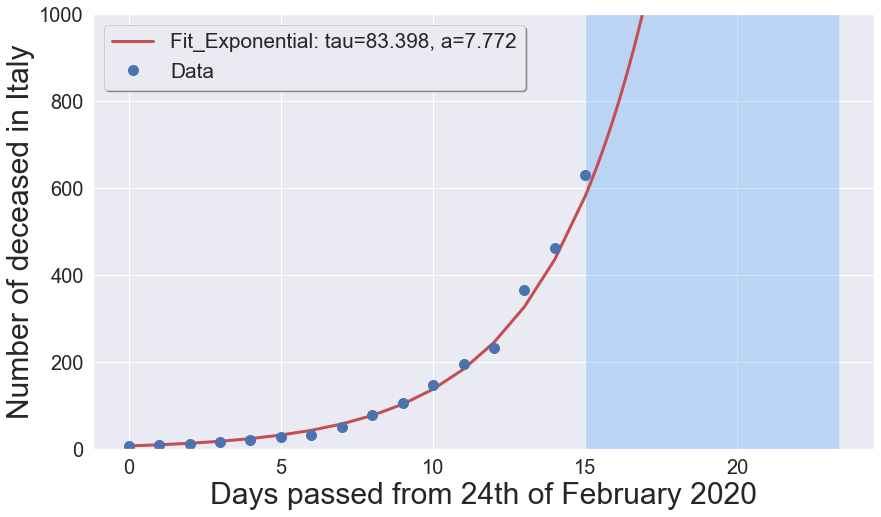

In [99]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(new_tdata/24,Exponential(new_tdata,*popt_deaths_exp),'r',linewidth=3, label='Fit_Exponential: tau=%5.3f, a=%5.3f' % tuple(popt_deaths_exp))
#ax.plot(new_tdata/24, Verhulst(new_tdata, *popt_deaths), 'g--', linewidth=3, label='fit_logistic: K=%5.3f, P0=%5.3f, r=%5.3f' % tuple(popt_deaths))
ax.plot(tdata/24, deaths_data, 'o', label='Data',markersize=10)
ax.tick_params(labelsize=20)
plt.ylabel('Number of deceased in Italy',fontsize=30)
plt.xlabel('Days passed from 24th of February 2020',fontsize=30)
ax.set_ylim([0,1000])
legend = ax.legend(loc='upper left', shadow=True, fontsize='xx-large')
plt.axvspan(tdata[-1]/24,new_tdata[-1]/24, facecolor='#0080FF', alpha=0.2)
#plt.xticks(tdata,covid19_daily['Data'],rotation=50)

plt.savefig('./Plots/COVID-19_Deceased_Italy_Params.png')
plt.show()

In [100]:
tau_deceased = popt_deaths_exp[0]
a_deceased = popt_deaths_exp[1]
delta_tau_deceased = np.sqrt(pcov_deaths_exp[0,0])
delta_a_deceased = np.sqrt(pcov_deaths_exp[1,1])
t_deceased = PrettyTable(['Exponential Model', 'Value','Error'])
t_deceased.add_row(['tau', tau_deceased, delta_tau_deceased])
t_deceased.add_row(['a', a_deceased, delta_a_deceased])
print(t_deceased)

+-------------------+-------------------+--------------------+
| Exponential Model |       Value       |       Error        |
+-------------------+-------------------+--------------------+
|        tau        | 83.39826808669775 | 3.4199338262522683 |
|         a         | 7.772496062331867 | 0.9955419365338707 |
+-------------------+-------------------+--------------------+


### 1-Sigma confidence intervals - Exponential model for the number of deceased

\begin{align}
& \tau = 83.4 \pm 3.4 && &&& a = 8 \pm 1
\end{align}

### Better plot on the number of deceased

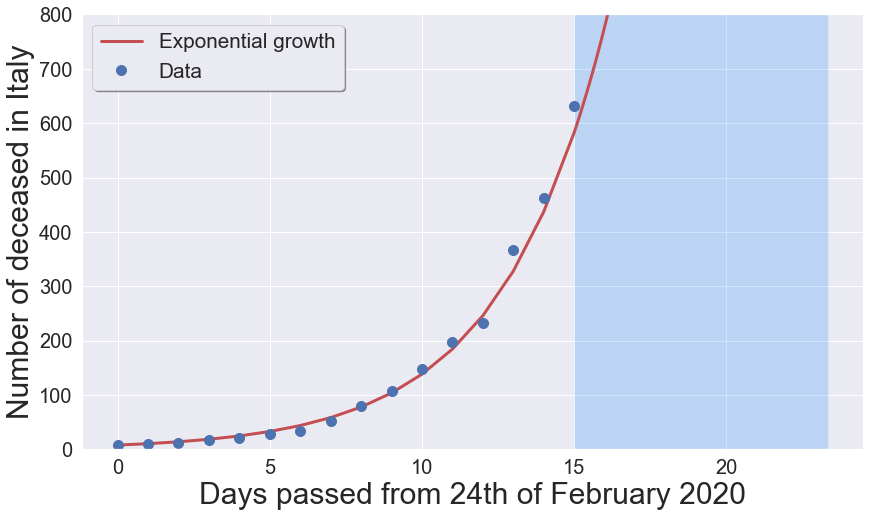

In [101]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(new_tdata/24,Exponential(new_tdata,*popt_deaths_exp),'r',linewidth=3, label='Exponential growth')
ax.plot(tdata/24, deaths_data, 'o', label='Data',markersize=10)
ax.tick_params(labelsize=20)
plt.ylabel('Number of deceased in Italy',fontsize=30)
plt.xlabel('Days passed from 24th of February 2020',fontsize=30)
ax.set_ylim([0,800])
legend = ax.legend(loc='upper left', shadow=True, fontsize='xx-large')
plt.axvspan(tdata[-1]/24,new_tdata[-1]/24, facecolor='#0080FF', alpha=0.2)
#plt.xticks(tdata,covid19_daily['Data'],rotation=50)

plt.savefig('./Plots/COVID-19_Deceased_Italy.png')
plt.show()

# Standard Sigmoid behaviour

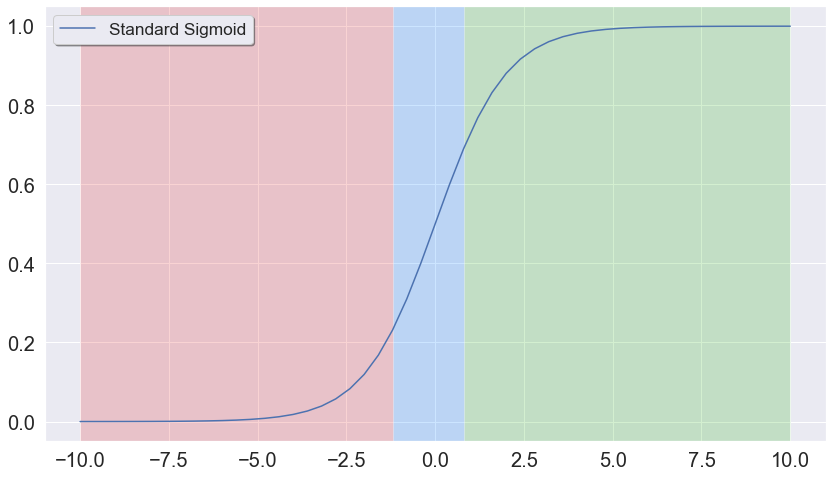

In [91]:
#Sigmoid plot
xdata = np.linspace(-10,10,num=51)
sigmoid_ydata = np.zeros(len(xdata))
for k in range(len(xdata)):
    sigmoid_ydata[k]=1/(1+np.exp(-(xdata[k])))
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(xdata, sigmoid_ydata, '-', label='Standard Sigmoid',markersize=10)
ax.tick_params(labelsize=20)
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.axvspan(xdata[0],xdata[22], facecolor='#E12525', alpha=0.2)
plt.axvspan(xdata[22],xdata[27], facecolor='#0080FF', alpha=0.2)
plt.axvspan(xdata[27],xdata[50], facecolor='#25AF15', alpha=0.2)
plt.savefig('./Plots/Sigmoide_Standard.png')
plt.show()